In [1]:
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import xesmf as xe
import glob

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import gcsfs 
import re
from datetime import datetime
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':700}
# %config InlineBackend.print_figure_kwargs={'bbox_inches': None}

In [2]:
# Import data file from google cloud
fs = gcsfs.GCSFileSystem()  # initializes cloud storage interface

input_path = 'YOUR_GCS_PATH/Taylor_data/Taylor_inputs'


In [ ]:
fs.ls(input_path)

In [4]:
# manually set the path and file name 
file_path = input_path + "/allproducts_pCO2_Taylor_stats_version20240825_1990-2020.csv"
df = pd.read_csv(file_path, index_col= 0)

In [5]:
df

Residual   observed        HPD      CMEMS       JENA        JMA  \
stats                                                                           
R_BATS        0.933359   1.000000   0.941681   0.944955   0.903496   0.935217   
STD_BATS     32.600659  36.542407  32.566799  31.540739  35.462399  28.029915   
RMSE_BATS    13.203849   0.000000  12.503740  12.956892  16.007577  15.324630   
R_HOT         0.927477   1.000000   0.938260   0.907752   0.887936   0.901864   
STD_HOT      21.448400  20.788085  21.322348  21.138533  23.079691  25.622540   
RMSE_HOT      8.783743   0.000000   7.696231   9.378827  11.360949  11.321679   
R_LDEO        0.961666   1.000000   0.927416   0.871714   0.899077   0.794457   
STD_LDEO     34.849722  37.604685  34.671730  33.044003  35.118721  33.269375   
RMSE_LDEO    10.444084   0.000000  14.115043  18.362817  17.398994  24.246742   
R_GLODAP      0.900089   1.000000   0.896611   0.851241   0.820785   0.744834   
STD_GLODAP   38.093007  40.457647  37.963757  38.093880  38.944897  36.422466   
RMSE_GLODAP  17.739324   0.000000  18.146383  21.914504  25.589659  30.389847   

                  NIES     SOMFFN   UoEX_WAT  OceanSODA     ACCESS  \
stats                                                                
R_BATS        0.946166   0.927867   0.926059   0.942021   0.942465   
STD_BATS     31.667589  29.328060  29.308624  30.927252  38.962708   
RMSE_BATS    12.416096  14.517769  15.152214  12.803260  18.394082   
R_HOT         0.927502   0.896313   0.893564   0.910146   0.910504   
STD_HOT      19.448282  16.921322  17.754431  20.025301  22.718719   
RMSE_HOT      7.950455   9.461876  10.450091   8.683174  16.180429   
R_LDEO        0.871910   0.856991   0.828947   0.873803   0.507896   
STD_LDEO     31.821764  31.250069  32.297768  33.519089  35.035988   
RMSE_LDEO    18.779421  20.887692  22.090448  19.357073  39.557314   
R_GLODAP      0.848839   0.812839   0.761902   0.849145   0.502281   
STD_GLODAP   35.028427  34.335350  36.545349  37.958206  45.235172   
RMSE_GLODAP  23.075201  27.169448  29.382152  23.607060  46.622400   

                CESM_ETHZ  CNRM_ESM2  FESOM2_REcoM       IPSL  MOM6_Princeton  \
stats                                                                           
R_BATS       9.381828e-01   0.908234      0.943897   0.939577        0.940143   
STD_BATS     3.836979e+01  38.018192     44.162376  37.463646       43.754738   
RMSE_BATS    1.329303e+01  20.273365     16.657253  17.455484       15.773159   
R_HOT        9.363017e-01   0.900993      0.936544   0.931889        0.935528   
STD_HOT      2.207301e+01  21.716291     22.286270  22.463205       22.691120   
RMSE_HOT     8.171962e+00  15.157043      9.103994   8.471633       13.730531   
R_LDEO       3.072412e-03   0.563564      0.597834   0.607312        0.680216   
STD_LDEO              inf  36.672890     44.563839  38.125362       39.524727   
RMSE_LDEO    1.351884e+36  36.377408     37.894598  35.039783       31.498500   
R_GLODAP     6.534825e-01   0.563863      0.631356   0.579682        0.655112   
STD_GLODAP   3.920971e+01  42.164436     52.564911  43.060036       52.842171   
RMSE_GLODAP  3.415038e+01  41.341324     42.257426  40.866820       41.235810   

             MPIOM_HAMOCC  MRI_ESM2_2  NEMO_PlankTOM12  NorESM_OC1_2  
stats                                                                 
R_BATS           0.923830    0.938246         0.935089      0.872860  
STD_BATS        49.398125   43.214527        40.584278     29.514166  
RMSE_BATS       28.392774   17.330075        19.148208     18.273994  
R_HOT            0.911250    0.932047         0.918513      0.931659  
STD_HOT         27.425406   22.552292        22.419975     23.503265  
RMSE_HOT        22.504390   11.078929        13.545771     28.943042  
R_LDEO           0.562971    0.538377         0.560197      0.577771  
STD_LDEO        42.431969   36.835346        39.221794     34.292435  
RMSE_LDEO       38.484923   37.134641        36.37421

In [6]:
df.columns

Index(['Residual', 'observed', 'HPD', 'CMEMS', 'JENA', 'JMA', 'NIES', 'SOMFFN',
       'UoEX_WAT', 'OceanSODA', 'ACCESS', 'CESM_ETHZ', 'CNRM_ESM2',
       'FESOM2_REcoM', 'IPSL', 'MOM6_Princeton', 'MPIOM_HAMOCC', 'MRI_ESM2_2',
       'NEMO_PlankTOM12', 'NorESM_OC1_2'],
      dtype='object')

In [7]:
# Currently or previously, we have these models/products
# If these are different from df.columns, you may need to make some changes on Taylor_locs() in the next cell
all_variables = ['Residual', 'observed', 'HPD', 'CMEMS', 'JENA', 'JMA', 'NIES', 'SOMFFN','UoEX_WAT', 'OceanSODA', 
             'ACCESS', 'CESM_ETHZ', 'CNRM_ESM2', 'FESOM2_REcoM', 'IPSL', 'MOM6_Princeton', 'MPIOM_HAMOCC', 
             'MRI_ESM2_2', 'NEMO_PlankTOM12', 'NorESM_OC1_2']


# you could select which models/products you want to include in the taylor diagram here.
# ('name', 'color', 'transparency') 
# transparency value ranges from 0 to 1, where 0 is fully transparent and 1 is fully opaque
select_variables = [
    ("Residual", "magenta", 1), 
    ("HPD", "blue", 1),      
    ("CMEMS", "red", 0.3),       
    ("JENA", "cyan", 0.3),        
    ("JMA", "limegreen", 0.3),   
    ("NIES", "black", 0.3),     
    ("SOMFFN", "darkviolet", 0.3), 
    ("UoEX_WAT", "green", 0.3),   
    ("OceanSODA", "gold", 0.3),   
    ("ACCESS", "coral", 0.3),    
    ("CESM_ETHZ", "saddlebrown", 0.3),
    ("CNRM_ESM2", "orchid", 0.3),  
    ("FESOM2_REcoM", "chartreuse", 0.3), 
    ("IPSL", "dodgerblue", 0.3),   
    ("MOM6_Princeton", "tomato", 0.3),   
    ("MPIOM_HAMOCC", "peru", 0.3), 
    ("MRI_ESM2_2", "slateblue", 0.3),
    ("NEMO_PlankTOM12", "springgreen", 0.3),
    ("NorESM_OC1_2", "turquoise", 0.3) 
]
# some possible colors = ["magenta", "blue", "red", "cyan", "limegreen", "black", "darkviolet", "green", 
                        # "gold", "coral", "saddlebrown", "orchid", "chartreuse", "dodgerblue", "tomato",
                        # "peru", "slateblue", "springgreen", "turquoise", "firebrick"]

In [8]:
# Full version of all models/products
# select_variables = [
    # ("Residual", "magenta", 1), 
    # ("HPD", "blue", 1),      
    # ("CMEMS", "red", 0.3),       
    # ("JENA", "cyan", 0.3),        
    # ("JMA", "limegreen", 0.3),   
    # ("NIES", "black", 0.3),     
    # ("SOMFFN", "darkviolet", 0.3), 
    # ("UoEX_WAT", "green", 0.3),   
    # ("OceanSODA", "gold", 0.3),   
    # ("ACCESS", "coral", 0.3),    
    # ("CESM_ETHZ", "saddlebrown", 0.3),
    # ("CNRM_ESM2", "orchid", 0.3),  
    # ("FESOM2_REcoM", "chartreuse", 0.3), 
    # ("IPSL", "dodgerblue", 0.3),   
    # ("MOM6_Princeton", "tomato", 0.3),   
    # ("MPIOM_HAMOCC", "peru", 0.3), 
    # ("MRI_ESM2_2", "slateblue", 0.3),
    # ("NEMO_PlankTOM12", "springgreen", 0.3),
    # ("NorESM_OC1_2", "turquoise", 0.3) 
# ]

In [9]:
def Taylor_locs(start_yr, end_yr, location, select_variables, figname=None, show_legend=True, show_year_range=True):
    if location == 1:   # BATS
        rowstd = 1
        rowr = 0
        labelt = "BATS"
    if location == 2:   # HOT
        rowstd = 4
        rowr = 3
        labelt = "HOT"
    if location == 3:    # LDEO
        rowstd = 7
        rowr = 6
        labelt = "LDEO"
    if location == 4:   # GLODAP
        rowstd = 10
        rowr = 9
        labelt = "GLODAP"
    
    # Reference std
    stdref = df.iloc[rowstd, 1]  # grab correct row / column
    print(f'the reference standard deviation is: {stdref}')
    
    # based on select_variables, get those statistics and plot format
    statistics = []
    for var, color, alpha in select_variables:
        idx = df.columns.get_loc(var)
        statistics.append([df.iloc[rowstd, idx], df.iloc[rowr, idx], var, color, alpha])

    fig = plt.figure(figsize=(5, 5))

    dia = TaylorDiagram(stdref, fig=fig, label='Observed', extend=False)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name, colors, alpha) in enumerate(statistics):
        dia.add_sample(stddev, corrcoef,
                       marker='o', ms=12, ls='',
                       mfc=colors, mec=colors, color=colors, alpha=alpha,
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    plt.clabel(contours, inline=1, fontsize=12, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add title: database name
    fig.suptitle(labelt, size='x-large')  

    # Add the year range label on the left side of the y-axis, vertically centered
    if show_year_range:
        plt.text(-0.15, 0.5, f"{start_yr} - {end_yr}", transform=dia._ax.transAxes,
                 fontsize=12, verticalalignment='center', horizontalalignment='center', rotation='vertical')

    # Add a figure legend
    if show_legend:
        fig.legend(dia.samplePoints,
                   [p.get_label() for p in dia.samplePoints],
                   numpoints=1, prop=dict(size='small'), loc='upper right', markerscale=.7)

    if figname is not None:
        # Edit the save path to the directory if necessary
        # Default path is your home directory
        fig.savefig(f'/home/jovyan/{figname}')

    plt.show()

    return dia

In [10]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.4), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using mpl_toolkits.axisartist.floating_axes.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform(apply_theta_transforms=False)

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        # you may also mannully set a number
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd
        # self.smax = 45

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        
        
    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        Figure.plot command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l
        
    def add_grid(self, *args, **kwargs):
        """Add a grid."""
        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

In [11]:
### IMPORTANT NOTES
## we need to mannully set the correct time range, based on the start and end year we set in the Input_Talor.ipynb
start_year = 1990
end_year = 2020

the reference standard deviation is: 36.54240746349036


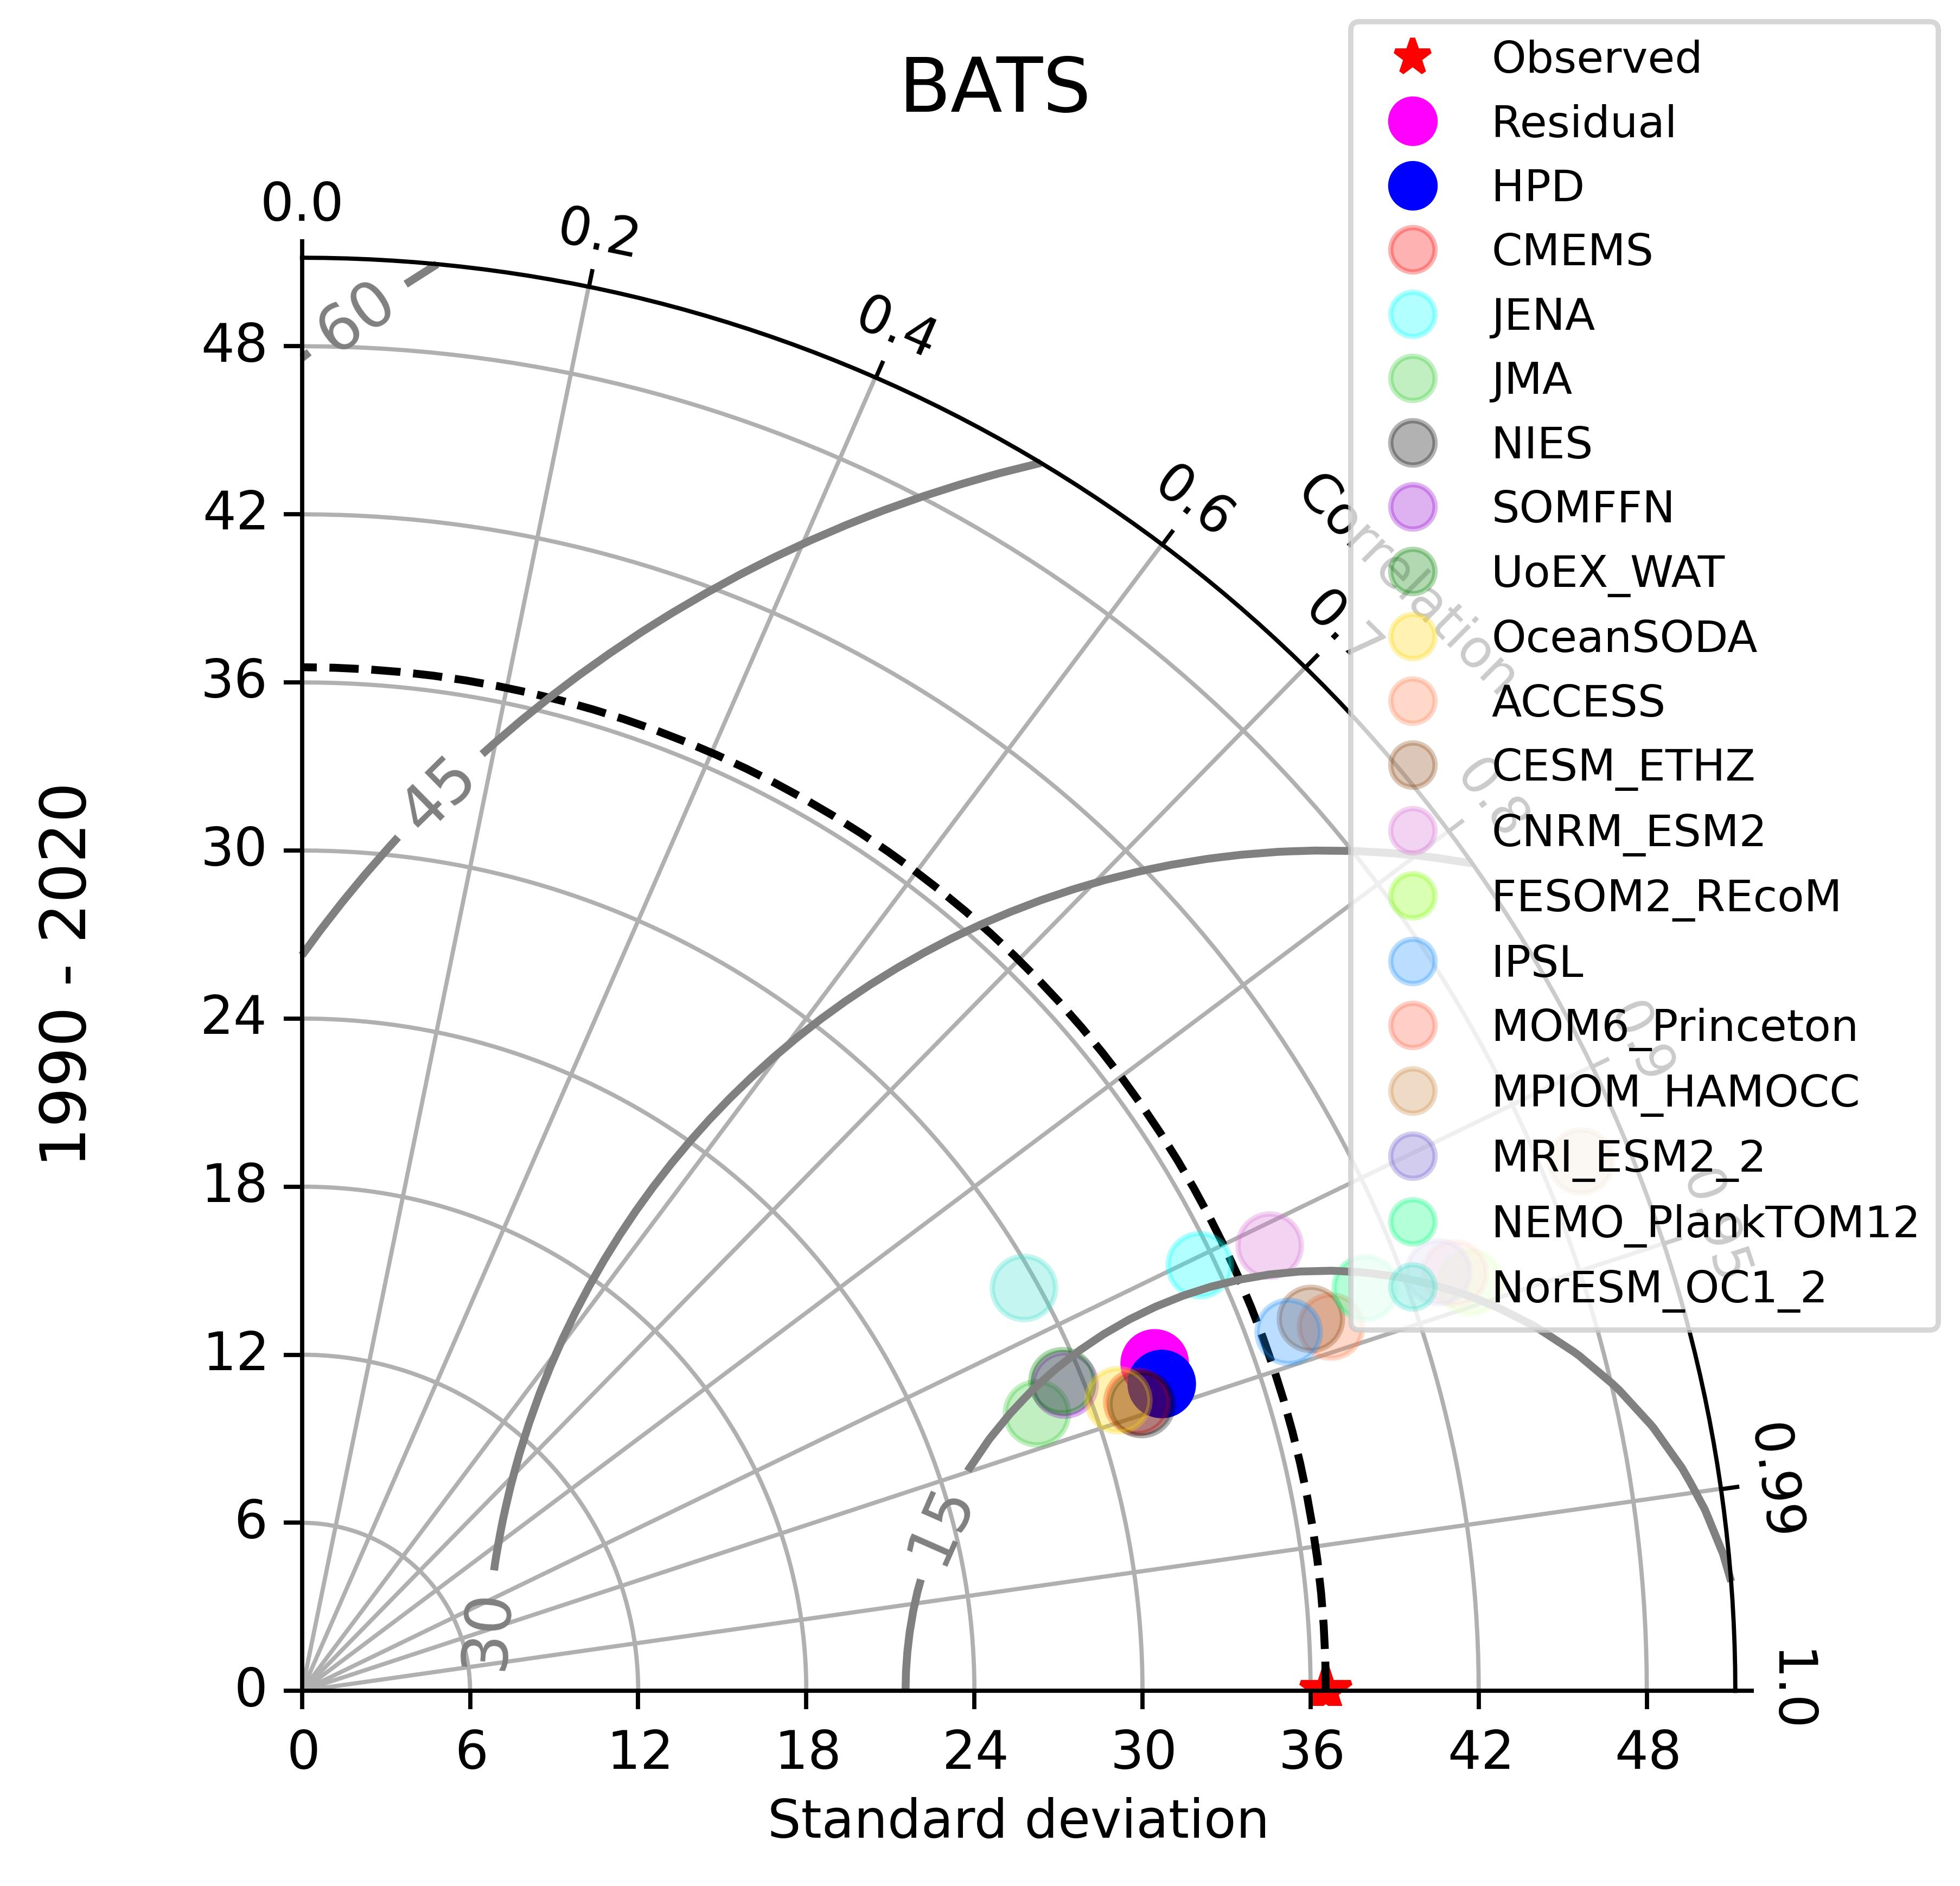

In [12]:
Taylor_locs(start_year,end_year,1, select_variables)

the reference standard deviation is: 20.788085151794085


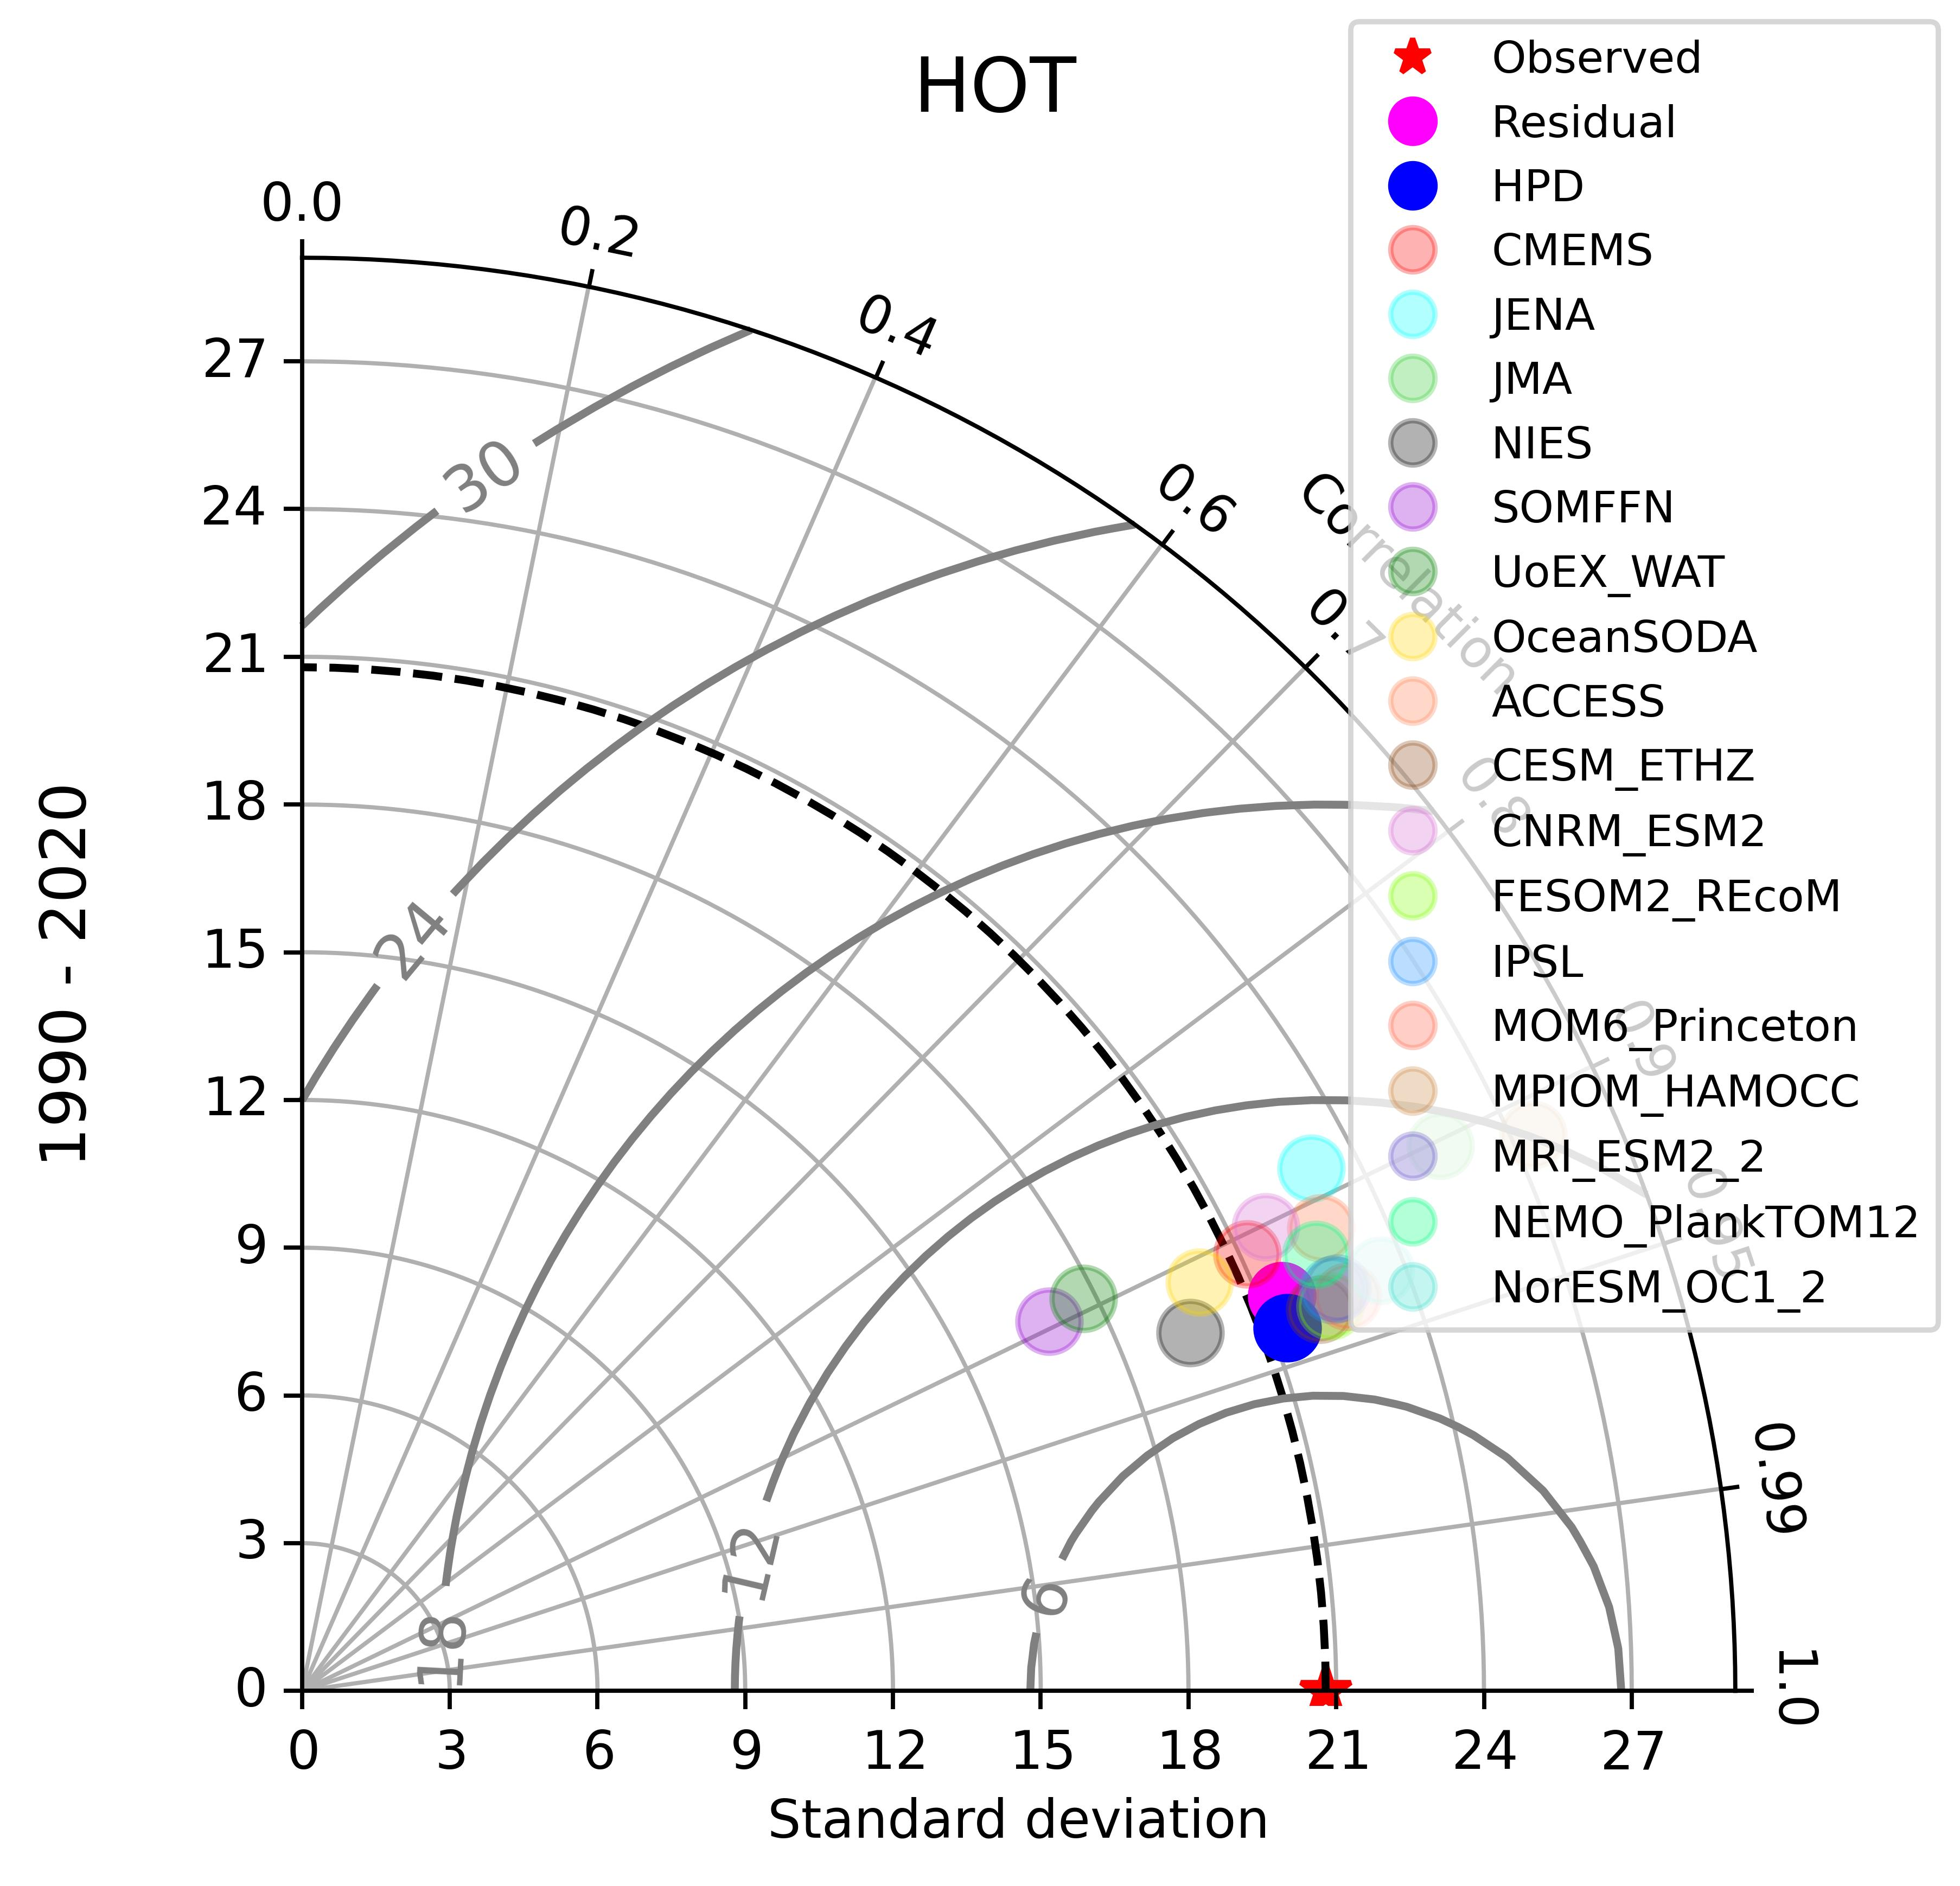

In [13]:
Taylor_locs(start_year,end_year,2, select_variables)

the reference standard deviation is: 37.60468540937381


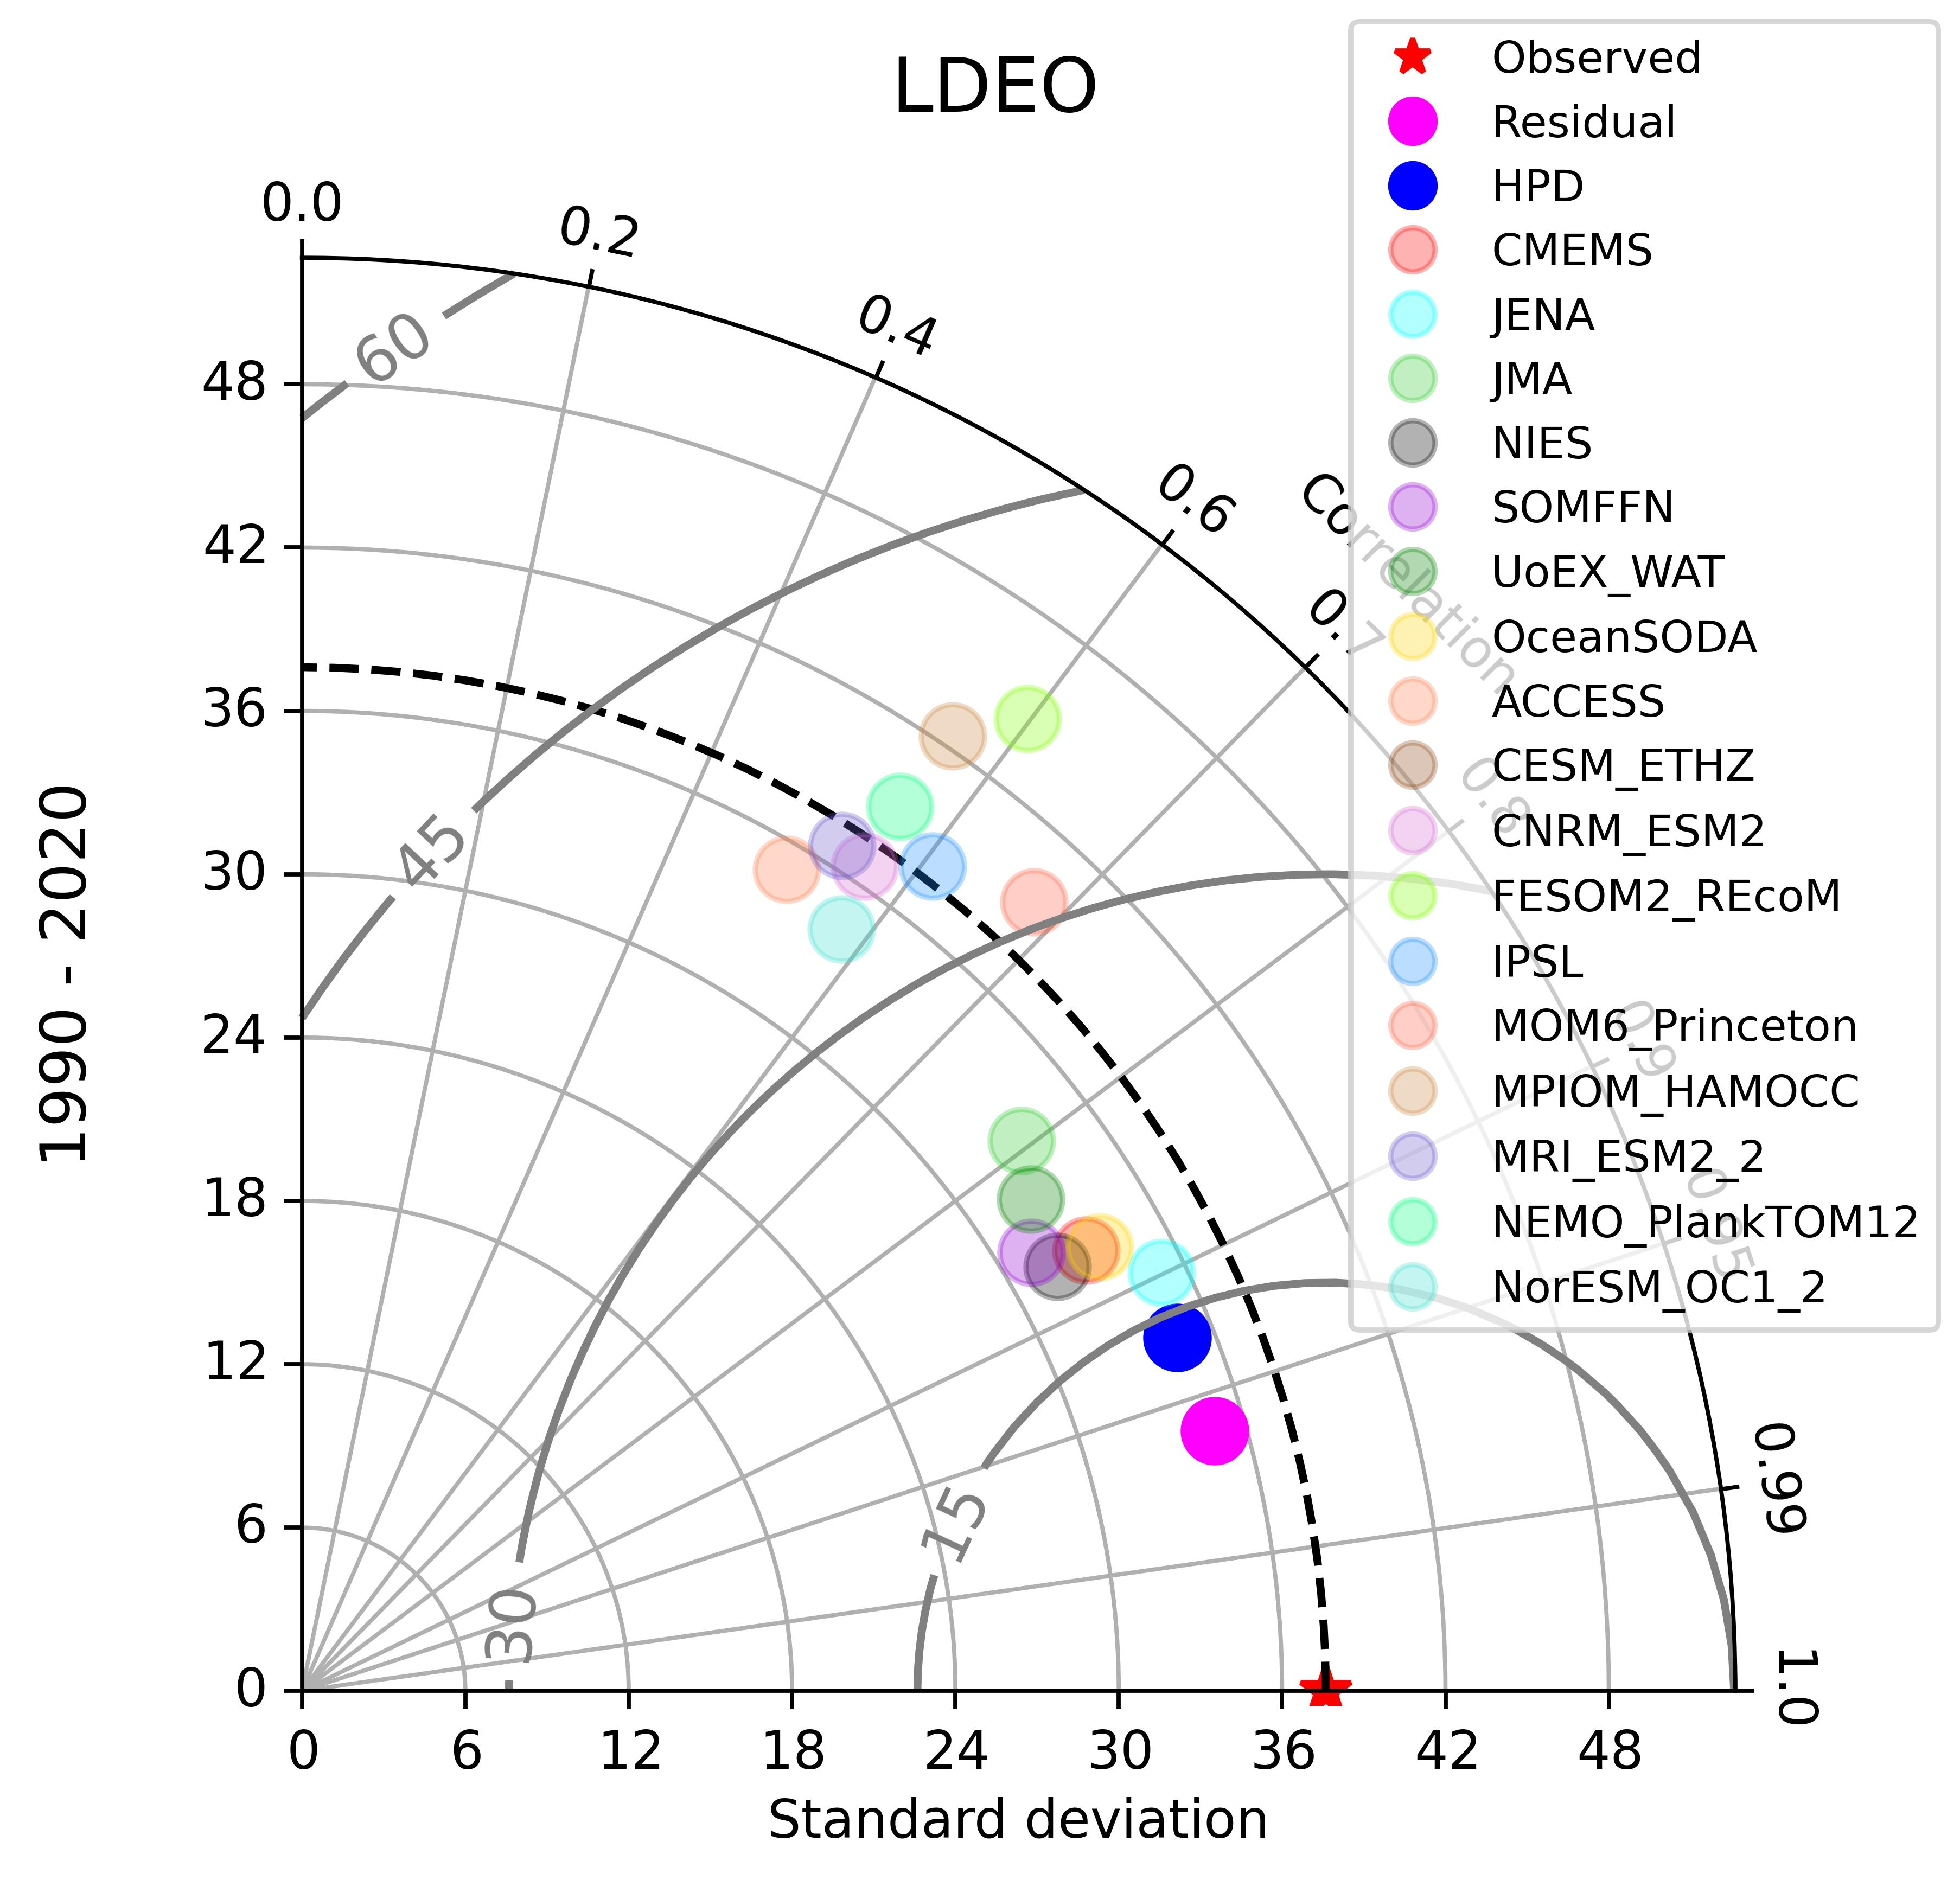

In [14]:
Taylor_locs(start_year,end_year,3, select_variables)

the reference standard deviation is: 40.4576470598822


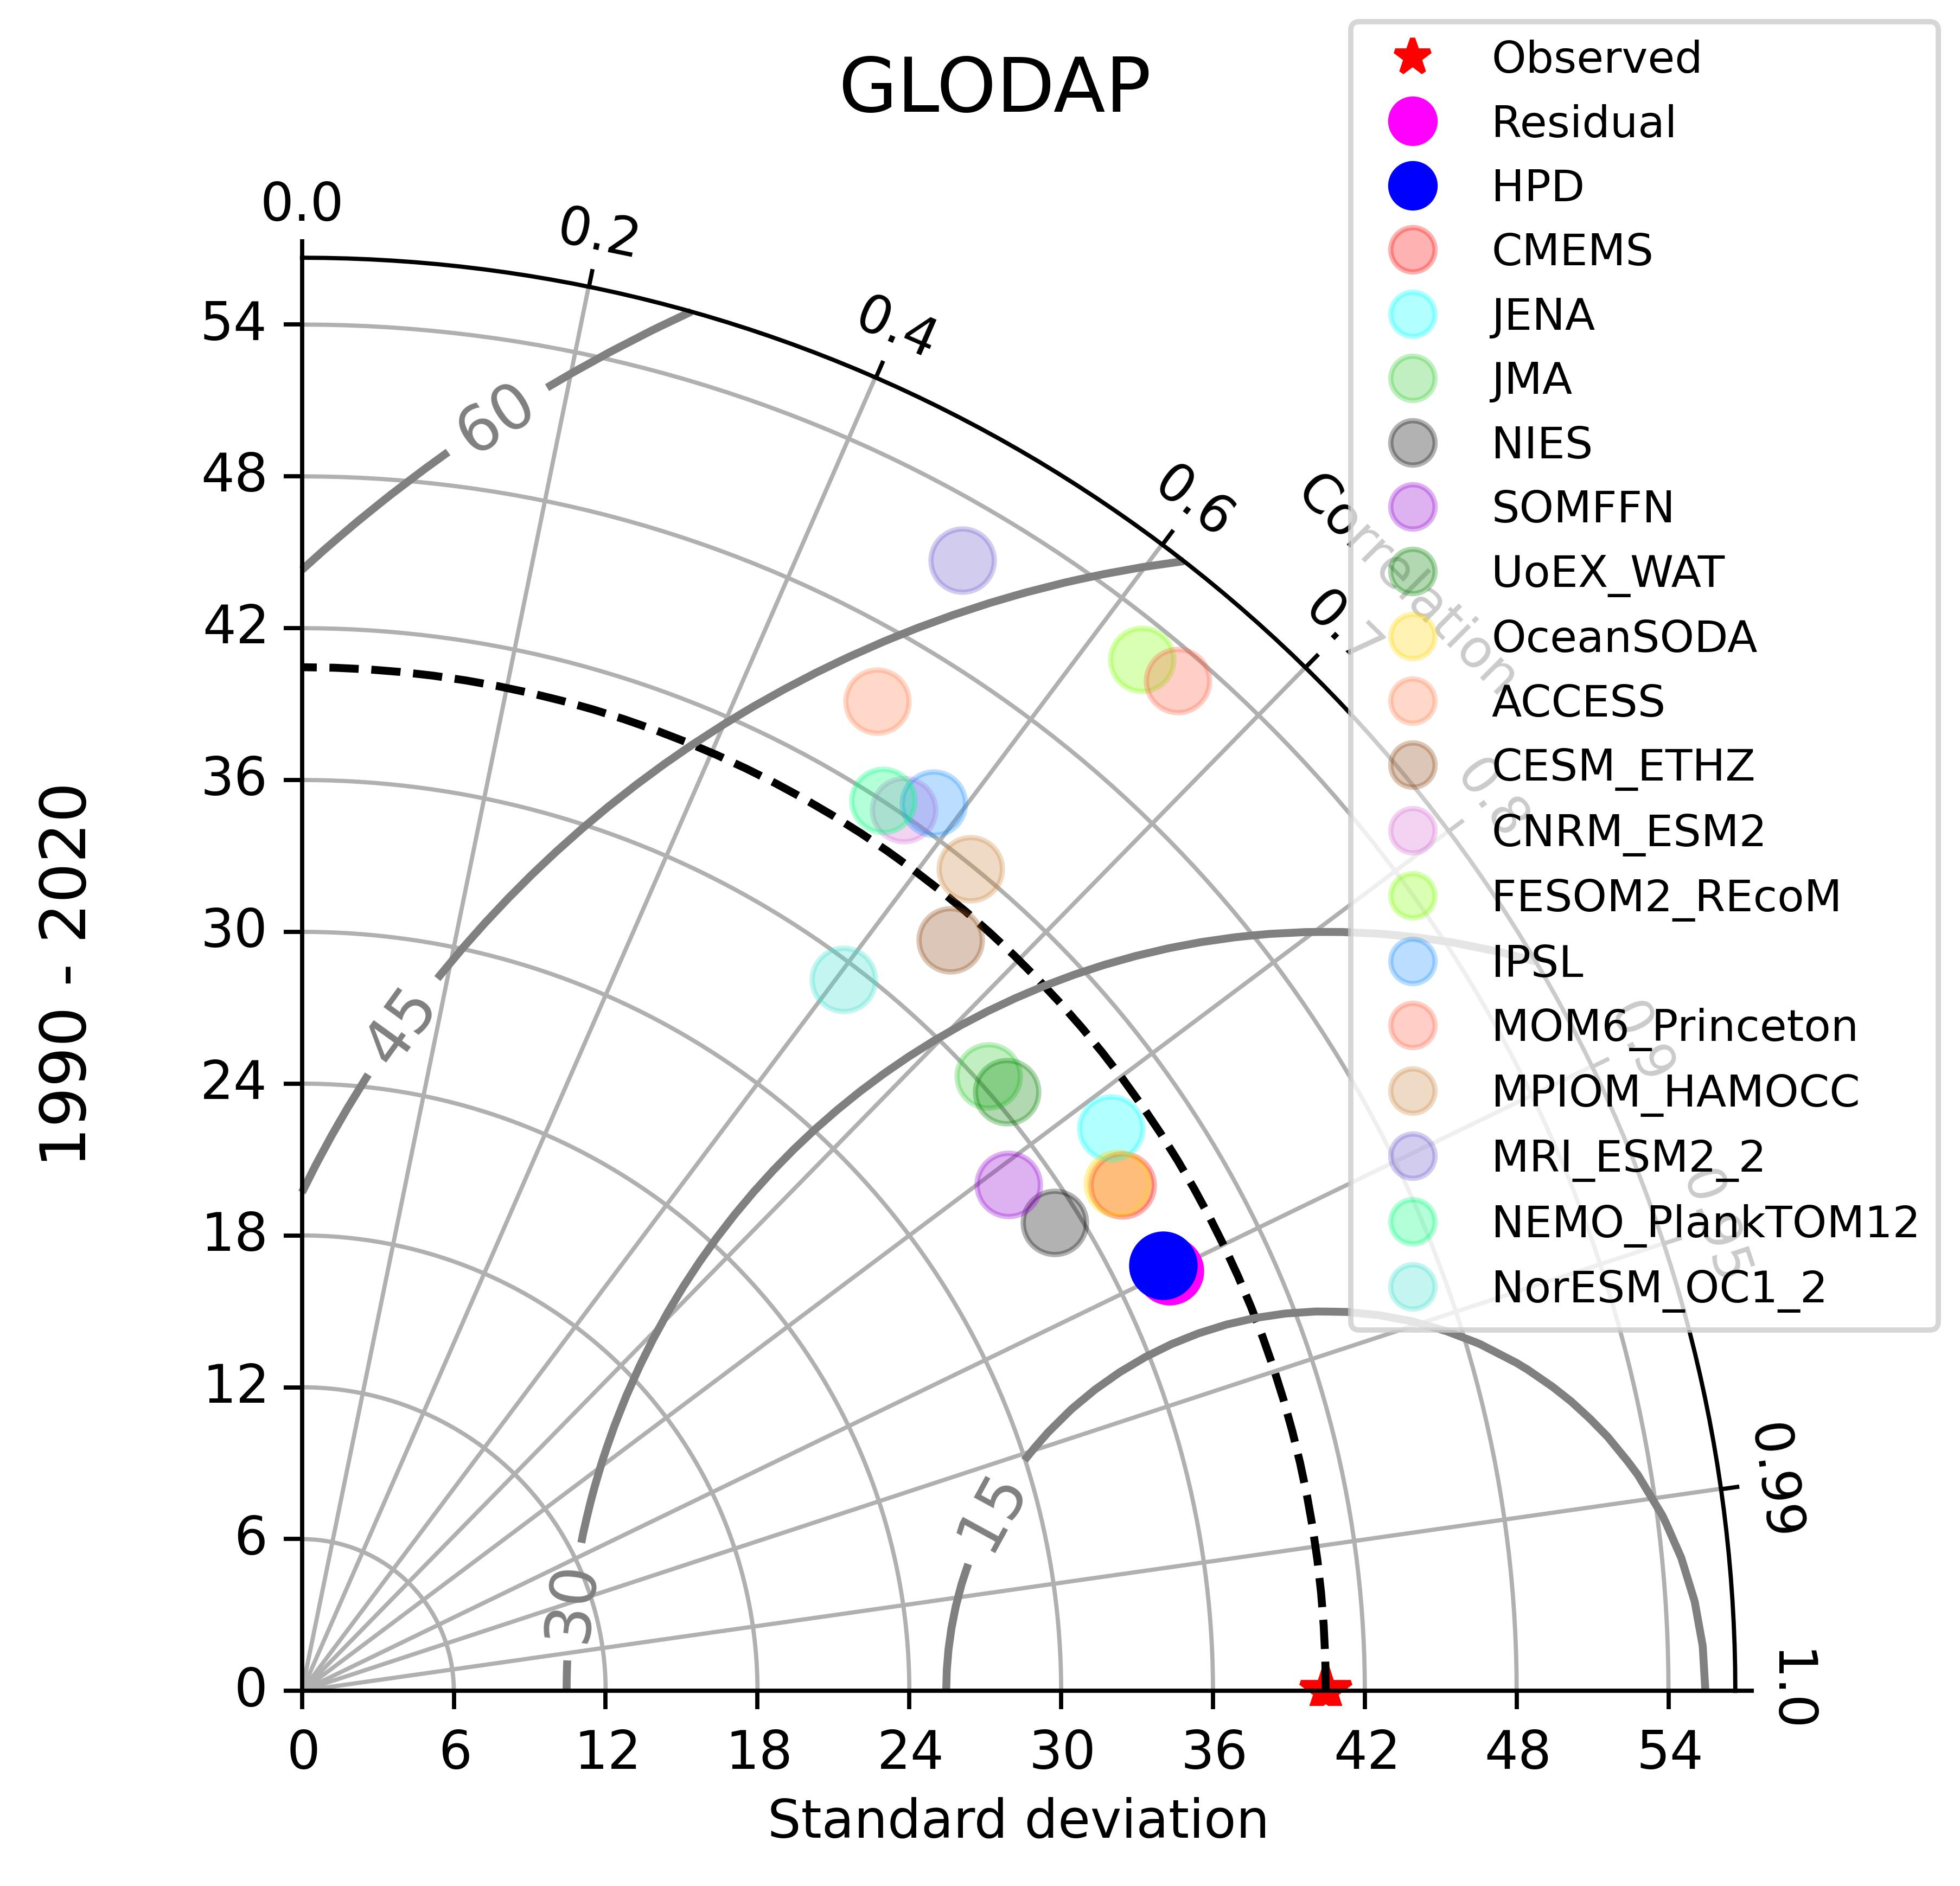

In [15]:
Taylor_locs(start_year,end_year,4, select_variables)

the reference standard deviation is: 36.54240746349036


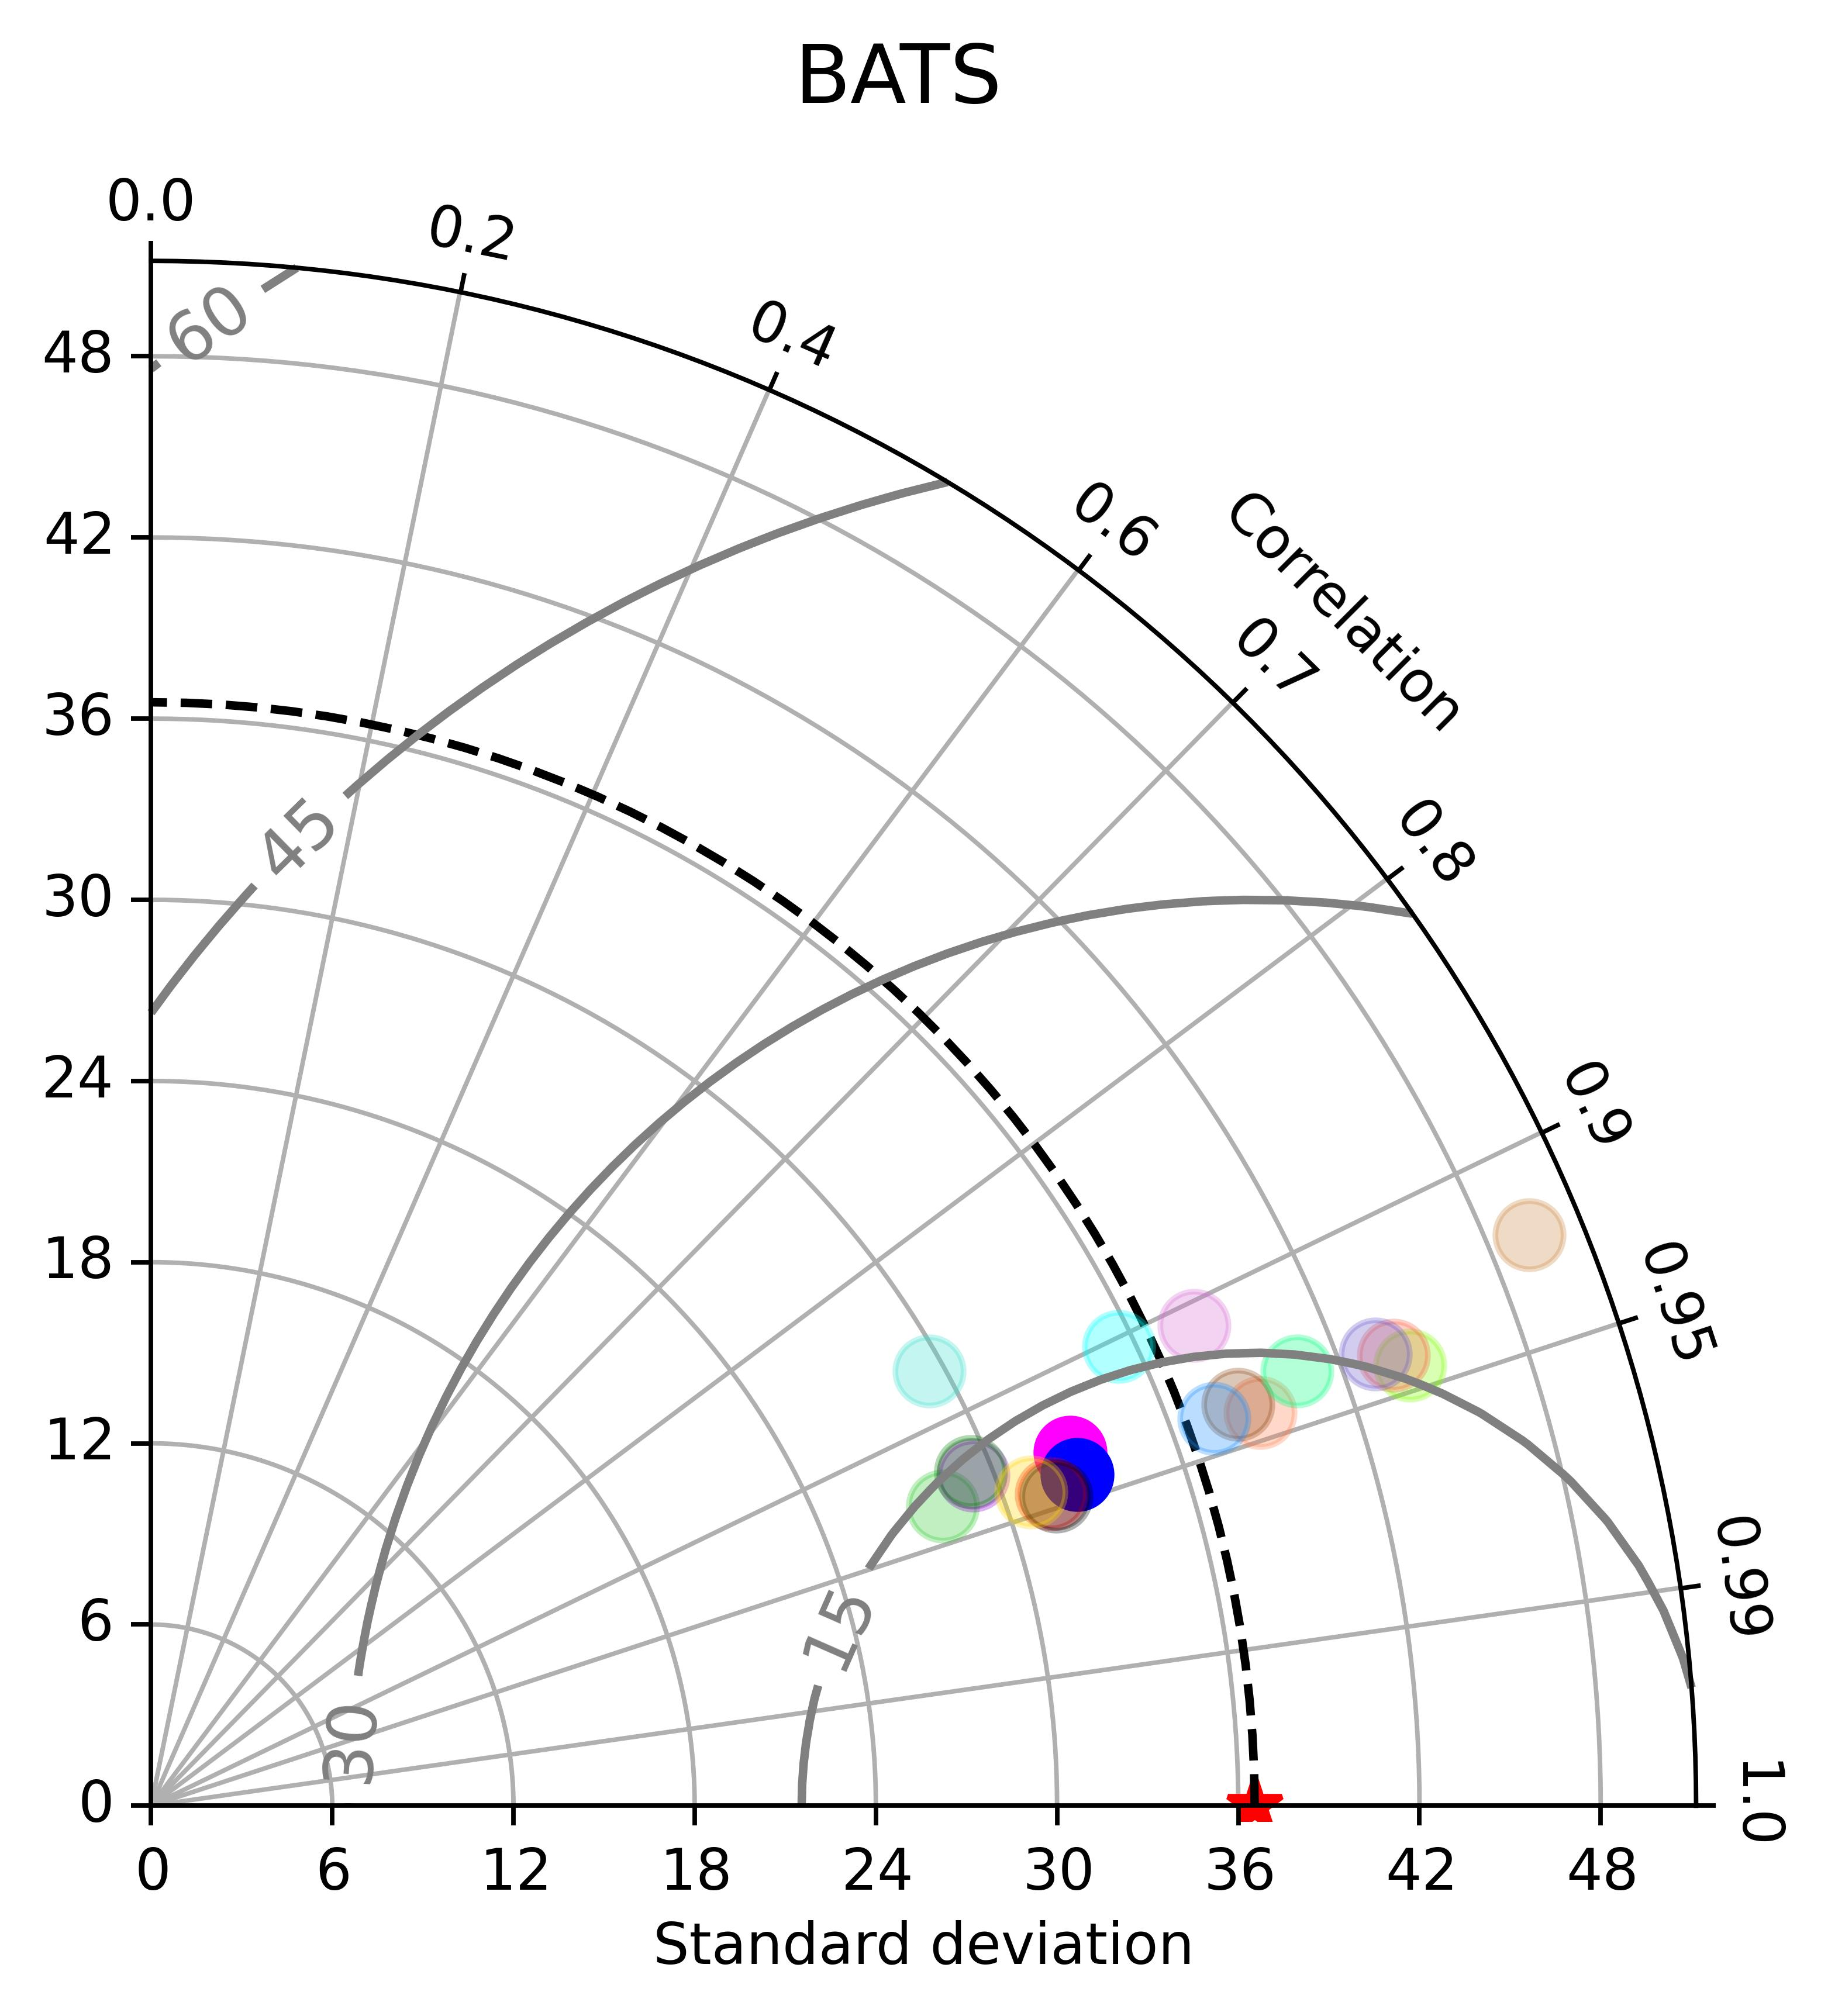

the reference standard deviation is: 20.788085151794085


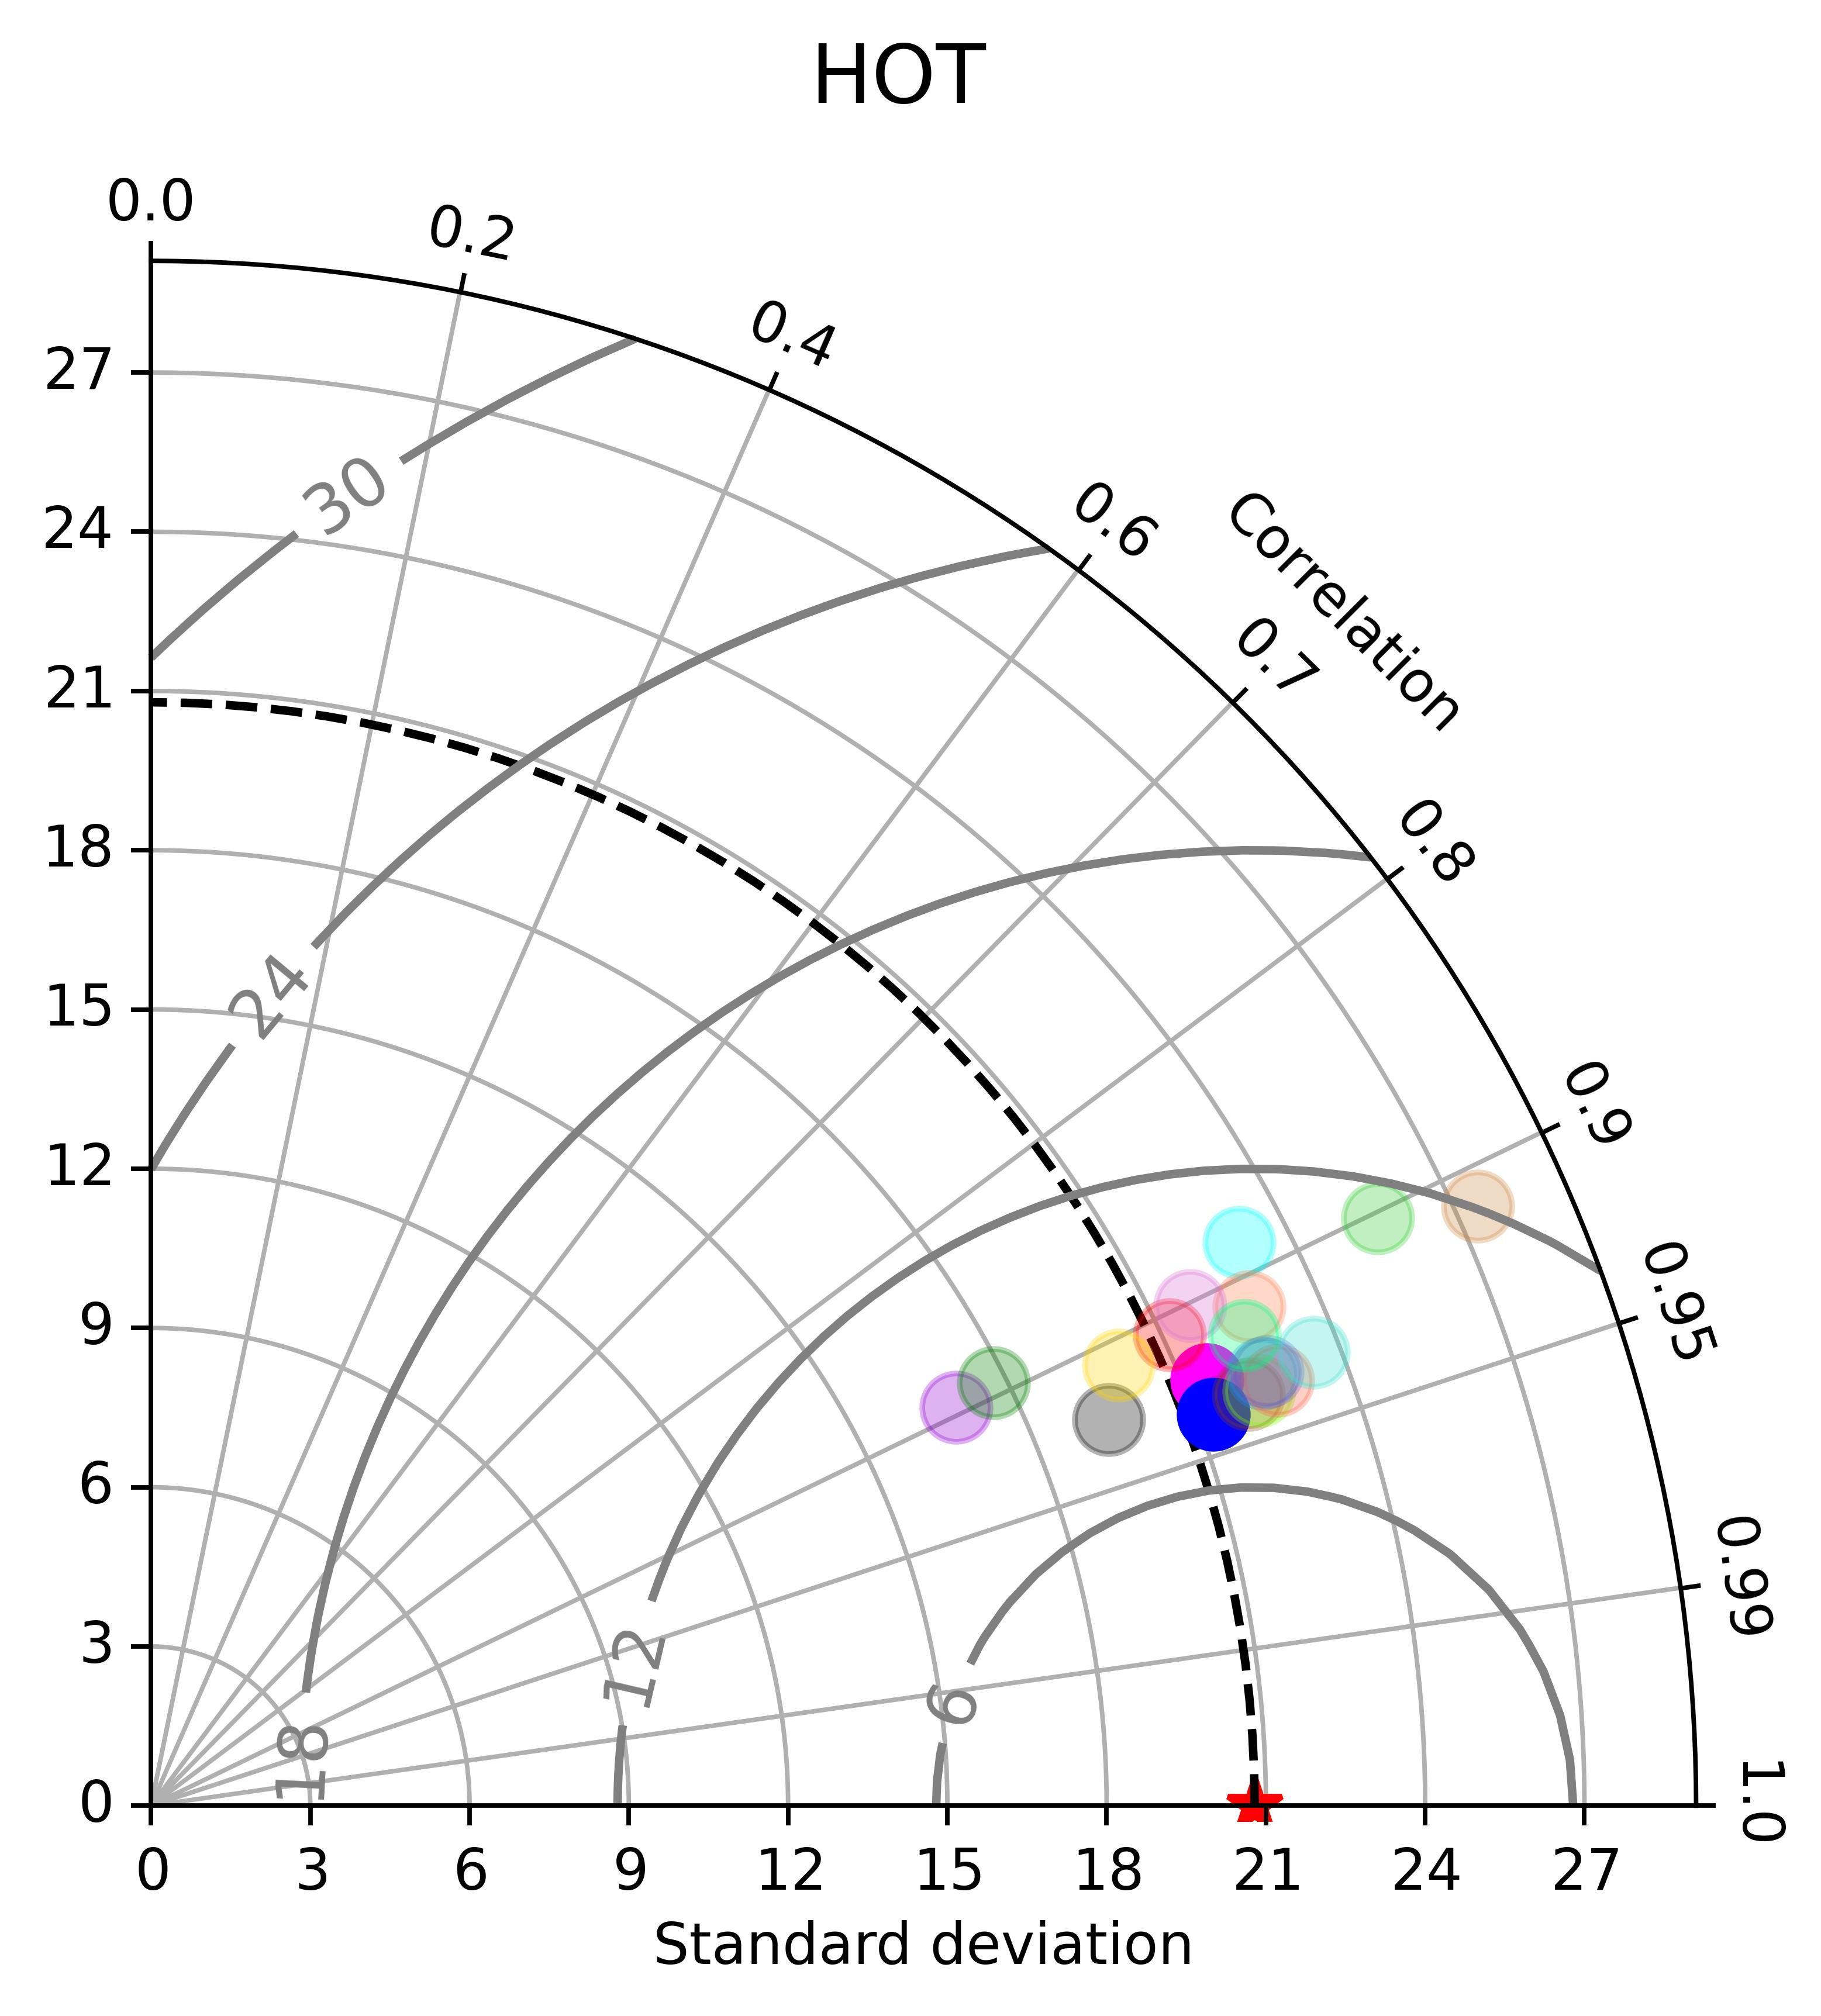

the reference standard deviation is: 37.60468540937381


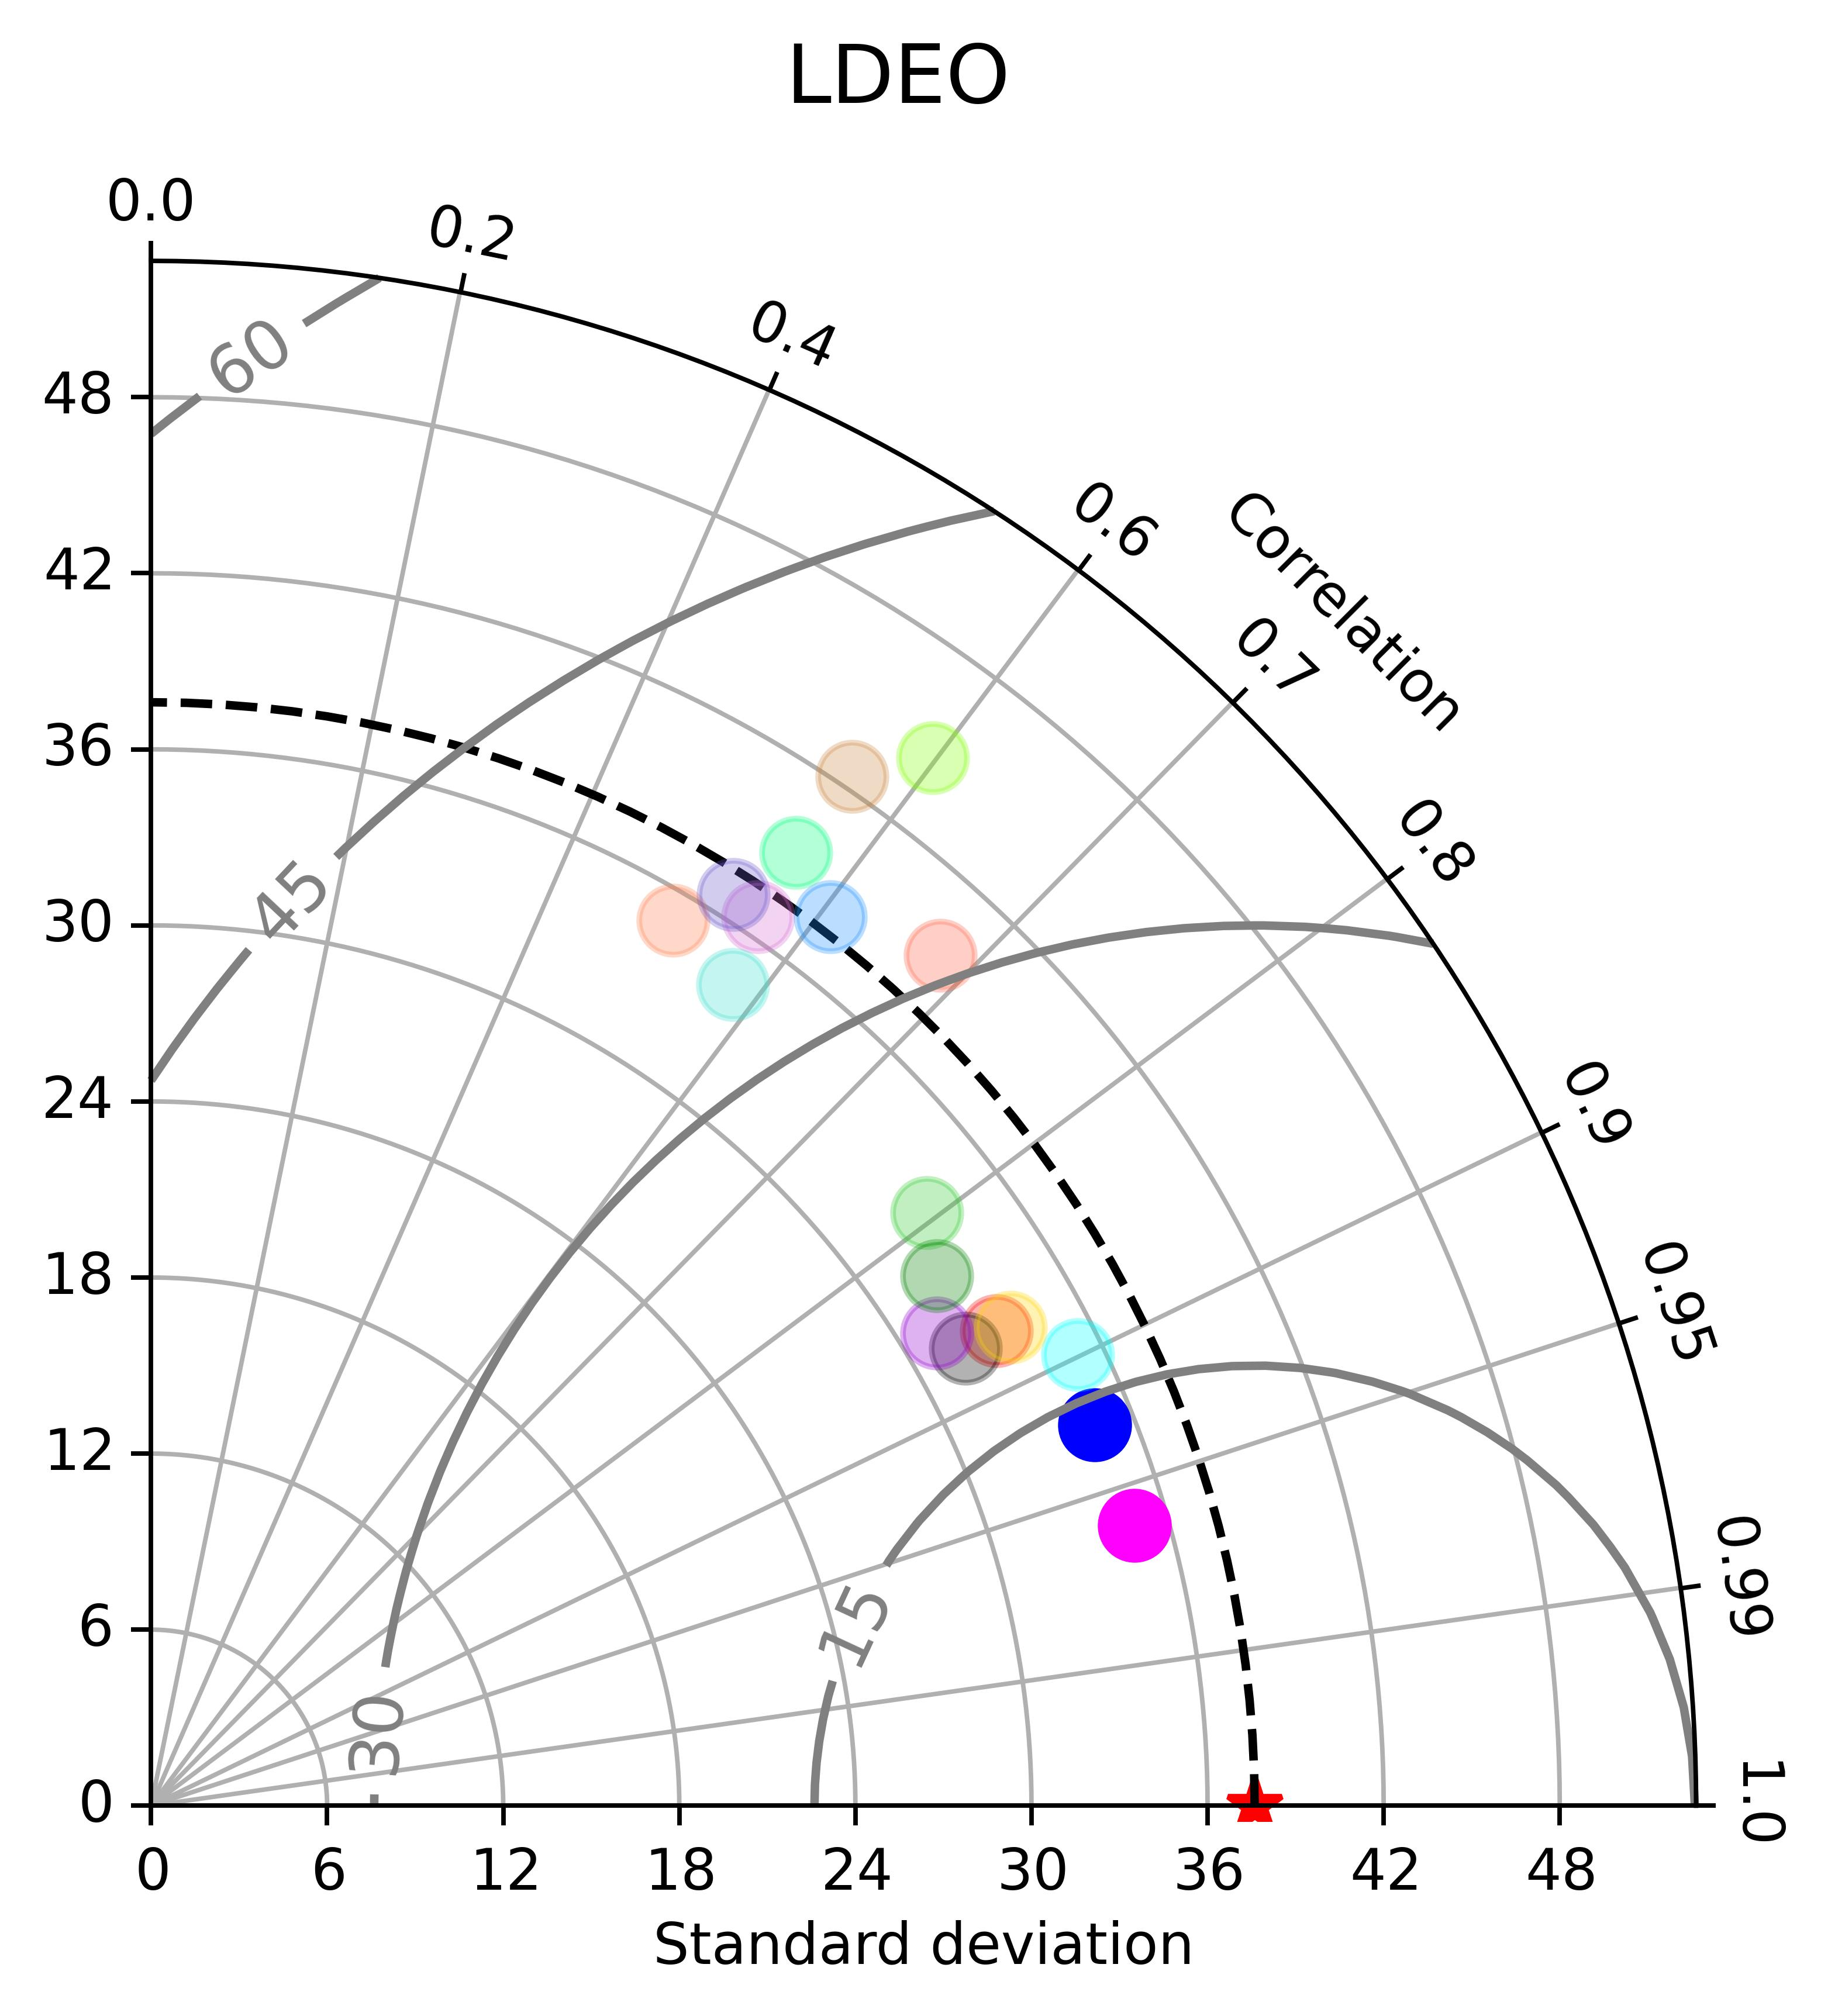

the reference standard deviation is: 40.4576470598822


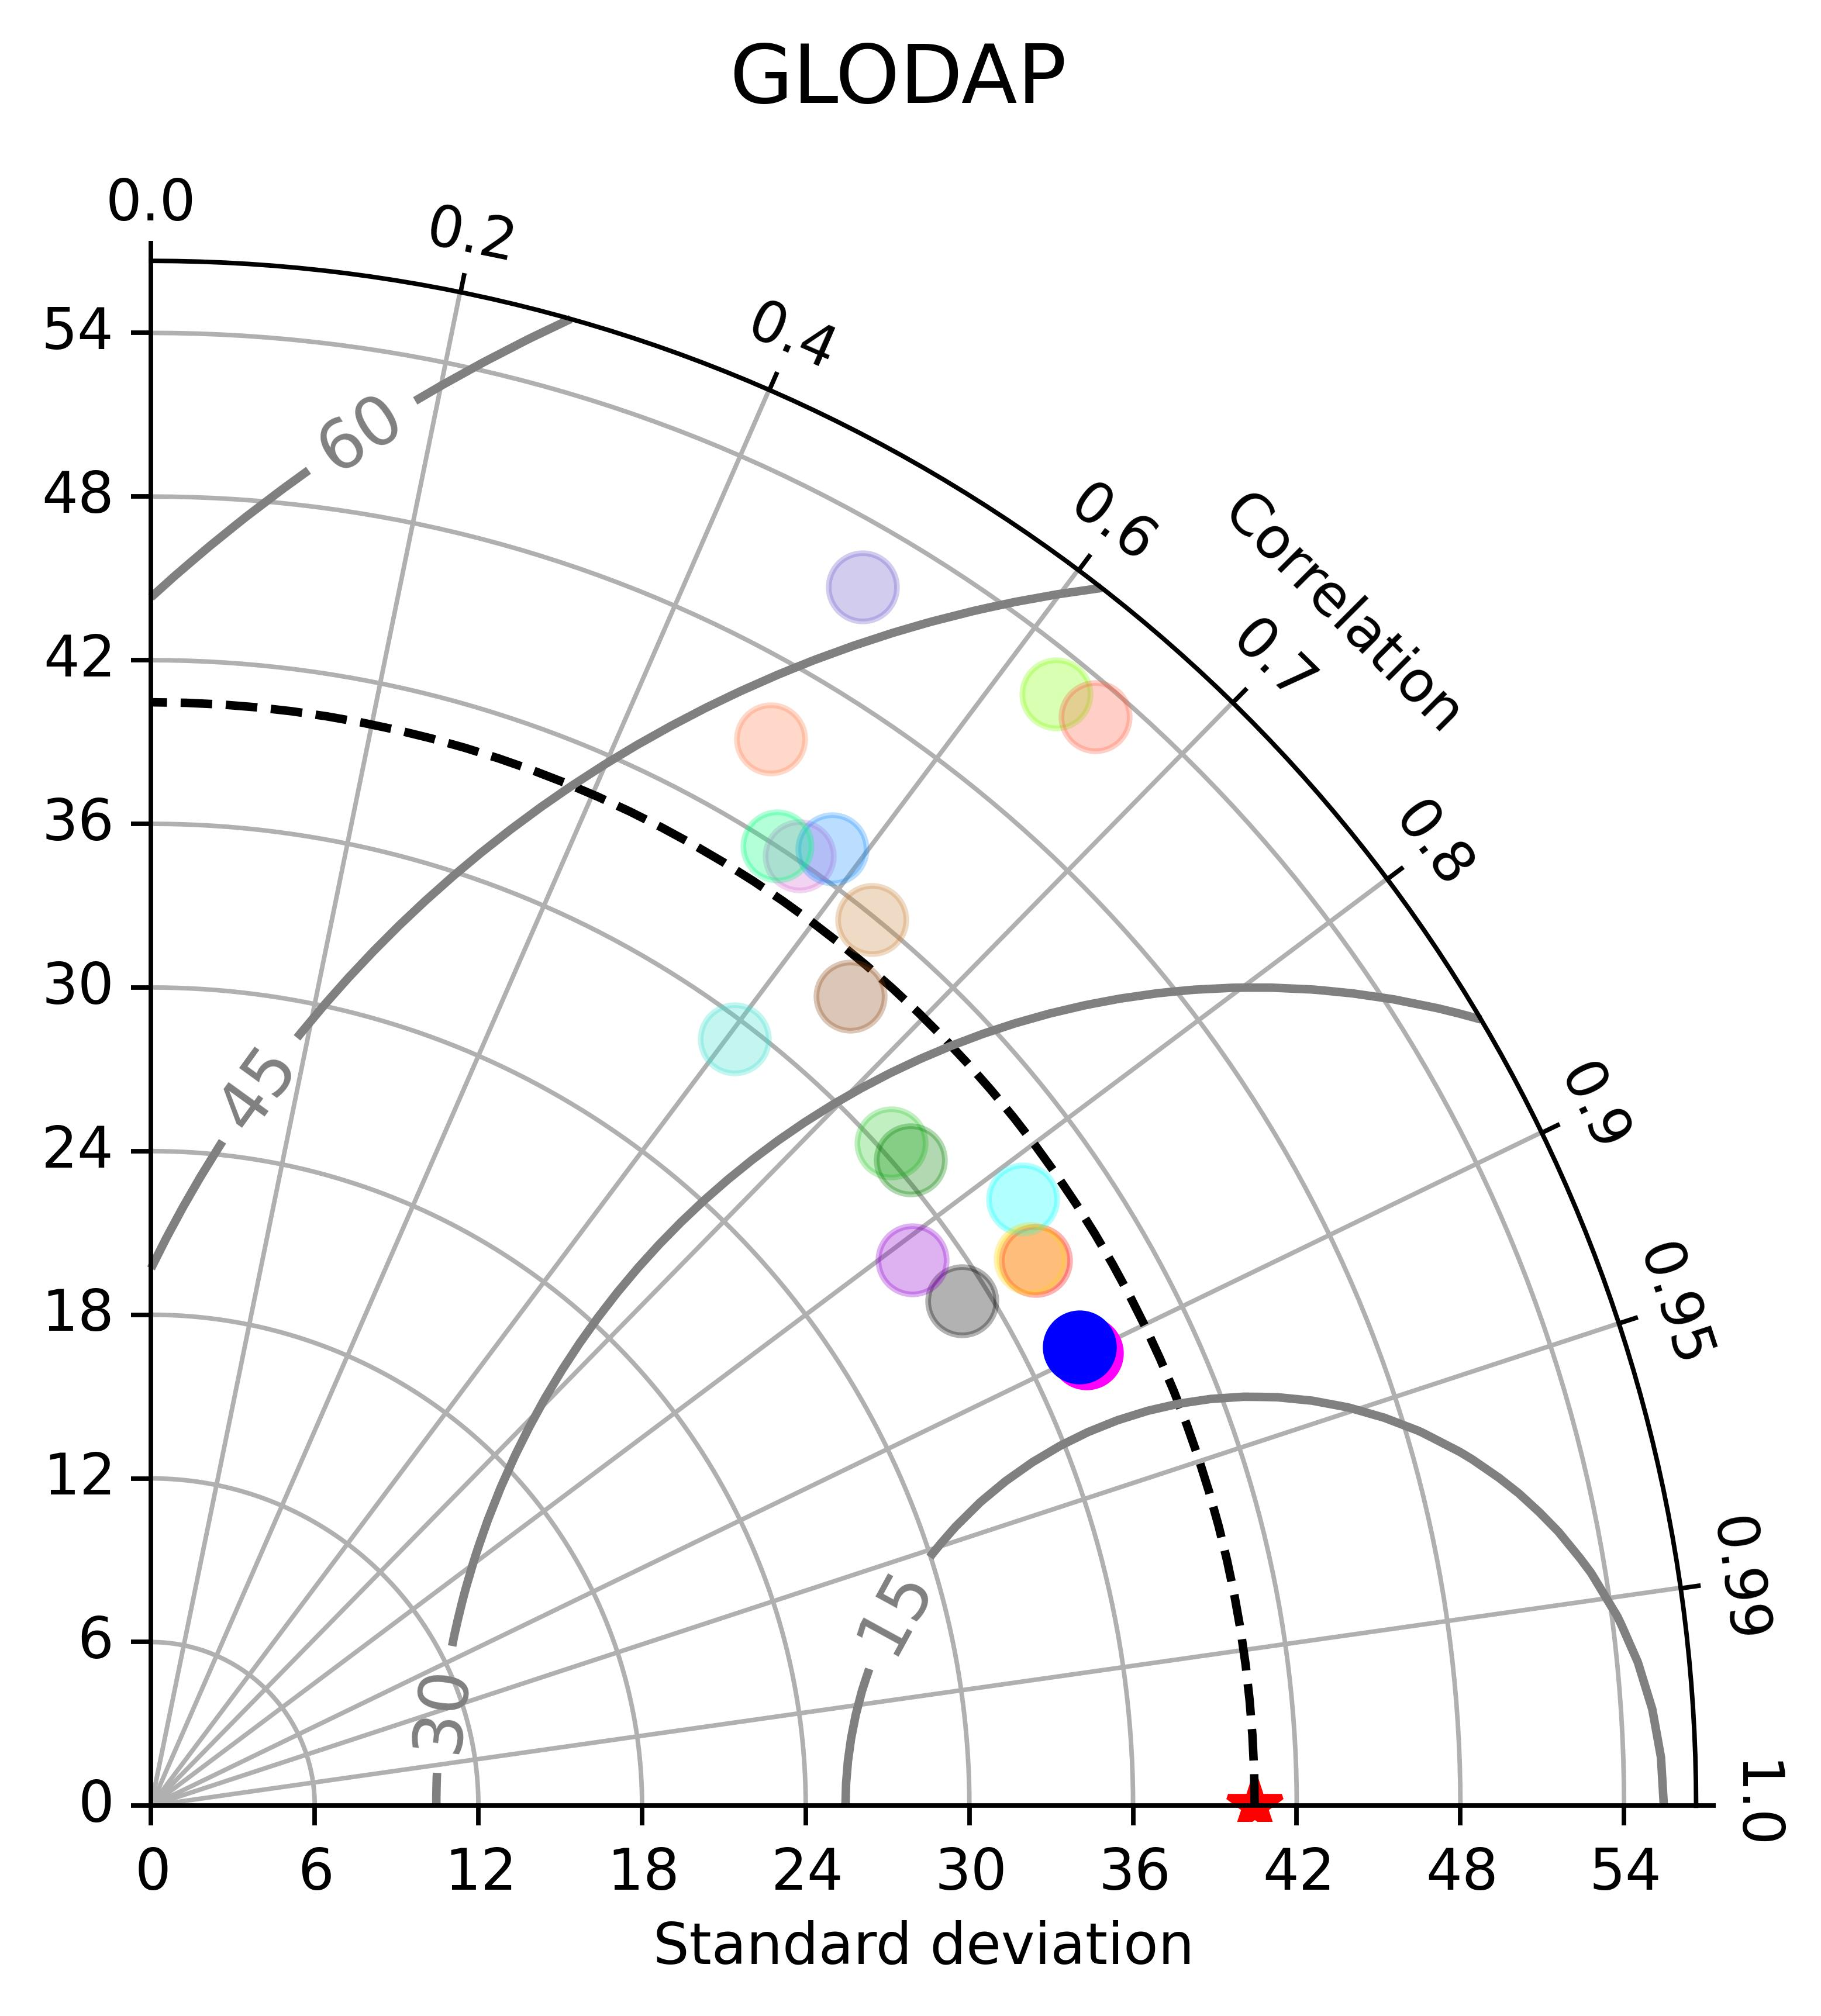

In [16]:
# If you want to have a plot consist of four sub-plots from 4 databases, run the following cells!

fig_name = f'Full_Taylor_Combined({start_year}-{end_year}).png'

# Get four figures for four databases
Taylor_locs(start_year, end_year, location=1, select_variables=select_variables, figname='BATS_Taylor.png', show_legend=False, show_year_range=False)
Taylor_locs(start_year, end_year, location=2, select_variables=select_variables, figname='HOT_Taylor.png', show_legend=False, show_year_range=False)
Taylor_locs(start_year, end_year, location=3, select_variables=select_variables, figname='LDEO_Taylor.png', show_legend=False, show_year_range=False)
Taylor_locs(start_year, end_year, location=4, select_variables=select_variables, figname='GLODAP_Taylor.png', show_legend=False, show_year_range=False)


In [17]:
image1 = Image.open('/home/jovyan/BATS_Taylor.png')
image2 = Image.open('/home/jovyan/HOT_Taylor.png')
image3 = Image.open('/home/jovyan/LDEO_Taylor.png')
image4 = Image.open('/home/jovyan/GLODAP_Taylor.png')

# Get the width and height of images
width, height = image1.size

# Create a new blank image with a size four times that of the original image (2x2)
combined_image = Image.new('RGB', (width * 2, height * 2))

# Paste the four images into different positions on the new image
# You may change the order here
combined_image.paste(image1, (0, 0))
combined_image.paste(image2, (width, 0))
combined_image.paste(image3, (0, height))
combined_image.paste(image4, (width, height))

# Save the combined image to directory.
# You may change the path and file name here
combined_image.save(f'/home/jovyan/{fig_name}')


In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

img = plt.imread(f'/home/jovyan/{fig_name}')
ax.imshow(img)
ax.axis('off')  # hide axis

# Add main title 
plt.suptitle(f'Combined Taylor Diagram ({start_year}-{end_year})', fontsize=20, y = 0.92) 

# based on select_variables, show legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=name) 
           for name, color, _ in select_variables]

# Add legend. First one is to add on the top left; Second one is lower center.
# fig.legend(handles, [name for name, _, _ in select_variables], loc='upper right', fontsize=12)
fig.legend(handles, [name for name, _, _ in select_variables], loc= 'lower center', fontsize=12, ncol=5)

# save to directory
plt.savefig(f'/home/jovyan/{fig_name}', bbox_inches='tight')

plt.show()